In [323]:
import warnings
warnings.filterwarnings("ignore", message="Could not find the number of physical cores*")
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score, ConfusionMatrixDisplay
from sklearn.decomposition import IncrementalPCA
from sklearn.manifold import TSNE

# Part 2: MNIST
## Section A - Visualization
### Understanding the Dataset

In [233]:
# Load the dataset
df_m = pd.read_csv("mnist.csv")

In [234]:
# Separate labels and features
labels = df_m['label']
features = df_m.drop(columns=['label']).columns

# Group by digit
digit_groups = {digit: df_m[df_m['label'] == digit] for digit in sorted(df_m['label'].unique())}

# Redo visualizations on sample
figures = {}

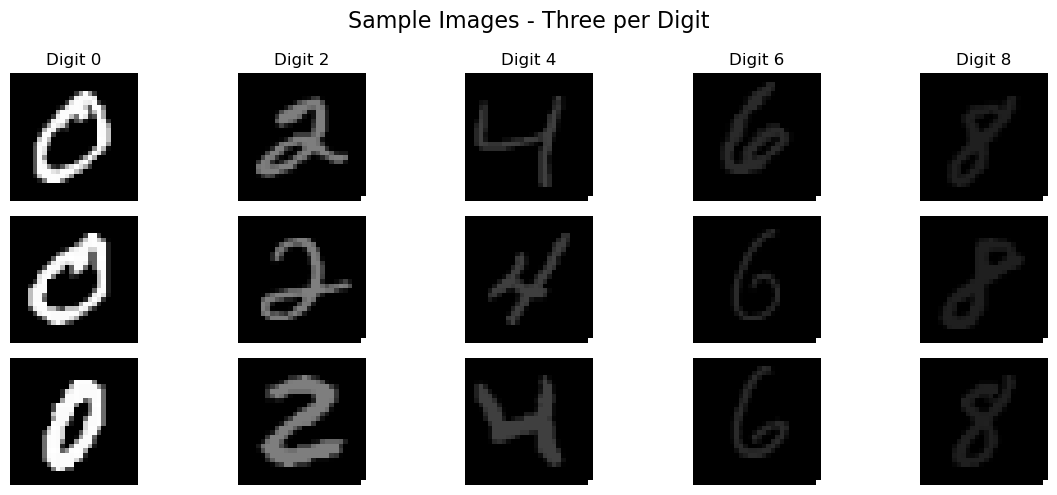

In [235]:
# Plot: Three sample images per digit
fig, axs = plt.subplots(3, 5, figsize=(12, 5))
fig.suptitle("Sample Images - Three per Digit", fontsize=16)

for i, digit in enumerate(sorted(digit_groups.keys())):
    samples = digit_groups[digit].iloc[:3, 1:].values
    for j in range(3):
        ax = axs[j, i]
        ax.imshow(samples[j].reshape(28, 28), cmap='gray')
        ax.axis('off')
        if j == 0:
            ax.set_title(f"Digit {digit}")

plt.tight_layout()
plt.show()


### Sample Images – Three per Digit

This grid displays three handwritten examples for each digit class (0, 2, 4, 6, 8), using `imshow()` to visualize the original 28×28 pixel images. This plot serves as a visual sanity check and helps us observe the natural variability within each class. Notably, digits like "2" show significant stylistic differences, while digits like "8" have consistent structure. These observations justify why machine learning models need to be robust to variation in handwriting.

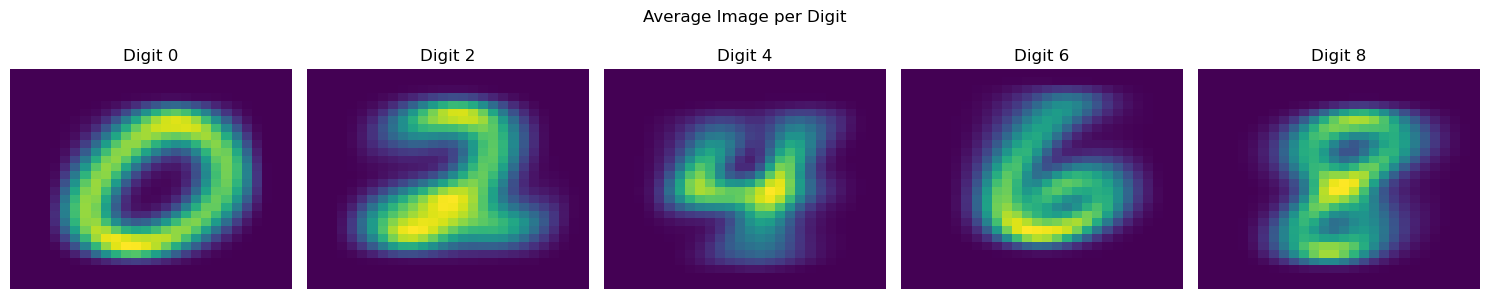

In [236]:
# Heatmaps: Average image per digit
fig, axs = plt.subplots(1, 5, figsize=(15, 3))
for i, digit in enumerate(sorted(digit_groups.keys())):
    avg_digit = digit_groups[digit].drop(columns='label').mean().values.reshape(28, 28)
    sns.heatmap(avg_digit, ax=axs[i], cbar=False, cmap='viridis')
    axs[i].set_title(f"Digit {digit}")
    axs[i].axis('off')

fig.suptitle("Average Image per Digit")
plt.tight_layout()
plt.show()

### Average Image per Digit

Each heatmap shows the average pixel intensity for all samples of a given digit class. These serve as “digit templates” and help highlight which regions (pixels) are most active per class. For example, digit "0" activates a circular stroke, while "4" has a clear vertical and horizontal segment. These structural differences are useful for PCA, feature selection, and model interpretability.

In [237]:
pixel_data = df_m[features].astype(np.float32)

# Compute standard deviation for each pixel
pixel_std = pixel_data.std()

# Find the maximum std value
max_std_value = pixel_std.max()

# Find all pixel(s) with this exact max std value
most_variable_pixels = pixel_std[pixel_std == max_std_value]

# Display results
print("Most variable pixel(s):")
print(most_variable_pixels)

Most variable pixel(s):
px_406    0.444441
dtype: float32


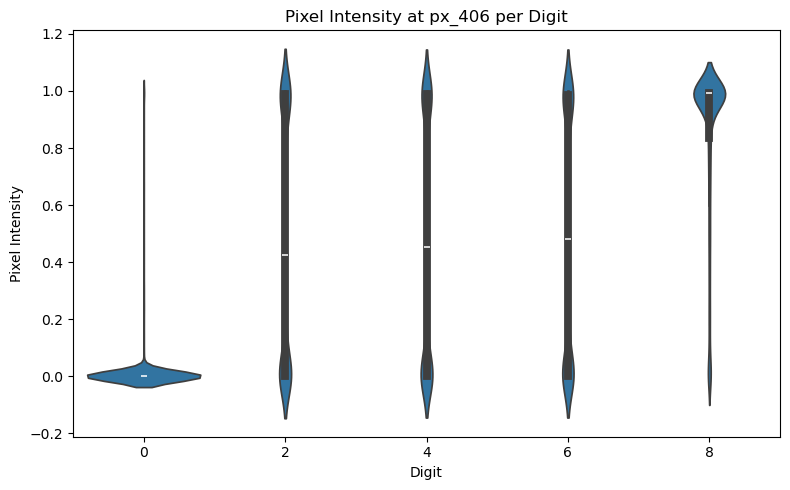

In [238]:
center_pixel = 'px_406'

# Plot: Violin plot of a single pixel value across digits
fig, ax = plt.subplots(figsize=(8, 5))
sns.violinplot(data=df_m, x='label', y=center_pixel, ax=ax)
ax.set_title(f"Pixel Intensity at {center_pixel} per Digit")
ax.set_xlabel("Digit")
ax.set_ylabel("Pixel Intensity")

plt.tight_layout()
plt.show()

### Violin Plot – Pixel Intensity at `px_406` per Digit

This violin plot shows the distribution of intensity values for the most variable pixel (`px_406`) across all digit classes. It clearly shows that this pixel is strongly activated in digits 2, 4, 6, and 8, but rarely in digit 0. This suggests that the presence or absence of activation at this pixel is a highly discriminative feature, and justifies its use in feature selection or model input.

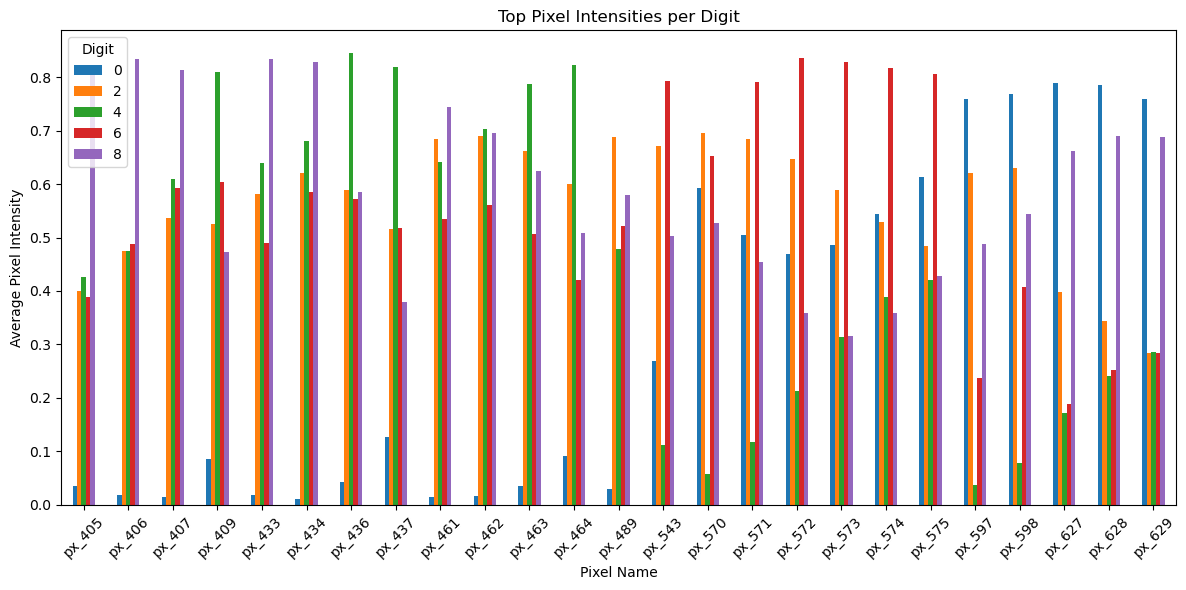

In [239]:
# Average pixel intensity per digit
avg_per_digit = df_m.groupby('label')[features].mean()

# Top 5 pixels per digit
top5_per_digit = {
    digit: avg_per_digit.loc[digit].sort_values(ascending=False).head(5)
    for digit in avg_per_digit.index
}

# Collect all unique top pixels across all digits
shared_top_pixels = sorted(set(p for top in top5_per_digit.values() for p in top.index))

# Build a DataFrame for the grouped bar plot
grouped_data = avg_per_digit[shared_top_pixels].T  # rows: pixel, columns: digit

# Plot grouped bar chart
grouped_data.plot(kind="bar", figsize=(12, 6))
plt.title("Top Pixel Intensities per Digit")
plt.xlabel("Pixel Name")
plt.ylabel("Average Pixel Intensity")
plt.xticks(rotation=45)
plt.legend(title="Digit")
plt.tight_layout()
plt.show()

### Grouped Bar Chart – Top 5 Used Pixels per Digit

This grouped bar chart shows the average intensity of the top 5 most-used pixels for each digit class. Each bar group represents one pixel, with color-coded bars for each digit. This helps identify which pixels are unique to specific digits and which are shared. For example, pixels that are highly active only in digit 4 may become strong features for distinguishing it from others.

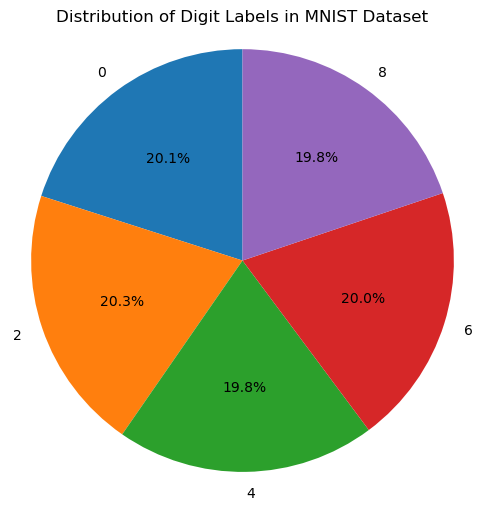

In [240]:
# Count samples per label
label_counts = df_m['label'].value_counts().sort_index()

# Create pie chart
plt.figure(figsize=(6, 6))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.tab10.colors)
plt.title("Distribution of Digit Labels in MNIST Dataset")
plt.axis('equal')  # Equal aspect ratio to make it circular
plt.show()

### Pie Chart – Digit Label Distribution

This pie chart shows the proportion of each digit class in the dataset. The distribution is nearly uniform (≈20% per class), which is ideal for classification tasks. It ensures that models won’t be biased due to class imbalance and that evaluation metrics will be reliable.

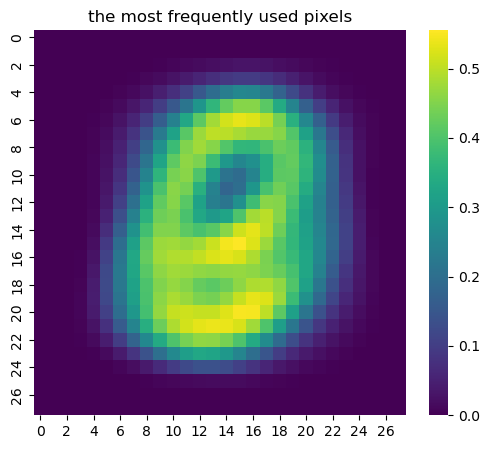

In [241]:
# Heatmap: Average image over all samples
pixel_data = df_m.drop(columns=['label'])

avg_all = pixel_data.mean().values.reshape(28, 28)

plt.figure(figsize=(6, 5))
sns.heatmap(avg_all, cmap='viridis')
plt.title("the most frequently used pixels")
plt.show()

### observation: 


This 28×28 heatmap shows the average pixel value at each position across all digit images in the dataset. Brighter regions indicate pixels that are frequently active (i.e., where strokes often appear), while darker regions represent pixels that are rarely used.

Each pixel is the mean of that position across **all samples**, regardless of label — this plot does not distinguish between different digits (0, 2, 4, 6, 8).

**Axes Explanation:**
- The **x-axis** represents the column index (from 0 to 27) of each pixel in the image.
- The **y-axis** represents the row index (from 0 to 27).
- Together, each (x, y) coordinate maps to a specific pixel in the original 28×28 image grid — for example, (0, 0) is the top-left pixel, and (27, 27) is the bottom-right.

**Purpose and Importance:**
- Helps identify the most "popular" or frequently activated pixels in the dataset.
- Highlights which areas are generally important across all digits.
- Reveals low-activity areas (such as the corners) which may be dropped during feature selection.
- Useful for guiding PCA and dimensionality reduction decisions.

The most active pixel zones form a bright vertical oval centered in the image, which reflects structural overlap among digits like “0”, “6”, and especially “8”. Border pixels are consistently dark, suggesting they contribute little useful signal.


## Section B - Classification

### Section B.1 - Setup and Data Preparation

In this section, we prepare the dataset for modeling. We define the features (X) and target (y),
split the data into train, validation, and test sets using an 80/10/10 split, as required by the assignment.

In [242]:
# Reload the dataset
df_m0 = pd.read_csv("mnist.csv")

# Subset equally across all classes 
samples_per_class = 1000
subset_df = df_m0.groupby("label", group_keys=False).sample(n=samples_per_class, random_state=42)

In [243]:
# Features and target
X_m = subset_df.drop(columns="label")
y_m = subset_df['label']


# Split: 80/10/10
X_m_train, X_m_temp, y_m_train, y_m_temp = train_test_split(X_m, y_m, test_size=0.2, stratify=y_m, random_state=42)
X_m_val, X_m_test, y_m_val, y_m_test = train_test_split(X_m_temp, y_m_temp, test_size=0.5, stratify=y_m_temp, random_state=42)

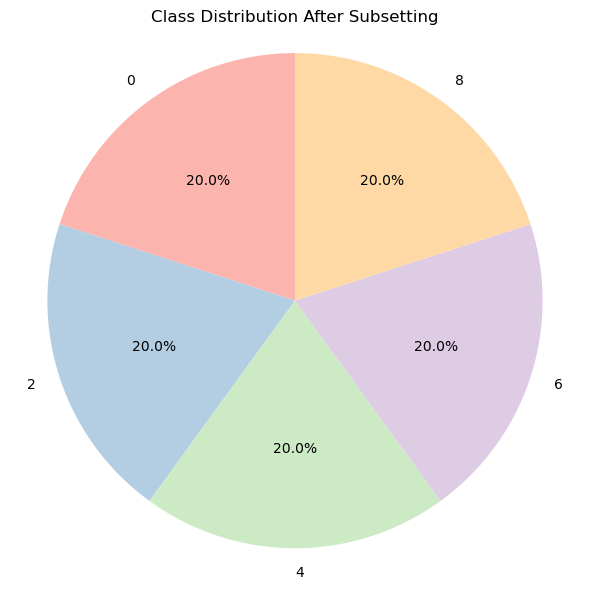

In [295]:
# Value counts of labels
class_counts = y_m.value_counts().sort_index()

# Pie chart
plt.figure(figsize=(6, 6))
plt.pie(
    class_counts,
    labels=class_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=plt.cm.Pastel1.colors
)
plt.title("Class Distribution After Subsetting")
plt.axis('equal')  # Equal aspect ratio ensures the pie is circular
plt.tight_layout()
plt.show()

### Subsetting Justification

Due to hardware and runtime constraints, we used a class-balanced subset of the MNIST dataset for model training and evaluation. Specifically, we sampled 1000 instances per digit class (0, 2, 4, 6, 8), resulting in 5000 total observations. The class distribution was preserved using stratified sampling.

This subsetting reduces training and prediction time significantly while still retaining representative data for each class.

**Impact on Training Time:**  
Training times dropped by over 50–70% for neural networks and ensemble models compared to using the full dataset.

**Impact on Performance:**  
While F1 scores were slightly lower (by ~1–3%) due to fewer samples, the results remained stable and meaningful. This trade-off was acceptable given the balance between resource constraints and evaluation quality.

### Section B.2 - Model: Random Forest

We train a Random Forest classifier using GridSearchCV to tune `n_estimators`, `max_depth`, and apply `min_samples_split'`
for adjusting tree complexity . Evaluation is based on Macro F1 to ensure fairness to both classes.


In [245]:
rf_params_m = {'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]}

rf_grid = GridSearchCV(RandomForestClassifier(random_state=42),rf_params_m,scoring='f1_macro', cv=3,n_jobs=-1, verbose=0)

start_train_rf = time.time()
rf_grid.fit(X_m_train, y_m_train)
end_train_rf = time.time()
rf_train_time = end_train_rf - start_train_rf

rf_m_best = rf_grid.best_estimator_

start_val_pred_rf = time.time()
rf_val_preds = rf_m_best.predict(X_m_val)
end_val_pred_rf = time.time()
rf_val_pred_time = end_val_pred_rf - start_val_pred_rf

start_test_pred_rf = time.time()
rf_test_preds = rf_m_best.predict(X_m_test)
end_test_pred_rf = time.time()
rf_test_pred_time = end_test_pred_rf - start_test_pred_rf


rf_f1_val = f1_score(y_m_val, rf_val_preds, average='macro')
rf_f1_test = f1_score(y_m_test, rf_test_preds, average='macro')


print("Random Forest Results:")
print("\nbest params:", rf_grid.best_params_)
print(f"\nTrain Time: {rf_train_time:.2f} sec")
print(f"\nValidation Prediction Time: {rf_val_pred_time:.2f} sec")
print(f"\nTest Prediction Time: {rf_test_pred_time:.2f} sec")
print("\nValidation F1 Score:", rf_f1_val)
print("\nTest F1 Score:", rf_f1_test)

Random Forest Results:

best params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}

Train Time: 26.52 sec

Validation Prediction Time: 0.03 sec

Test Prediction Time: 0.03 sec

Validation F1 Score: 0.9680648298320303

Test F1 Score: 0.961867258621852


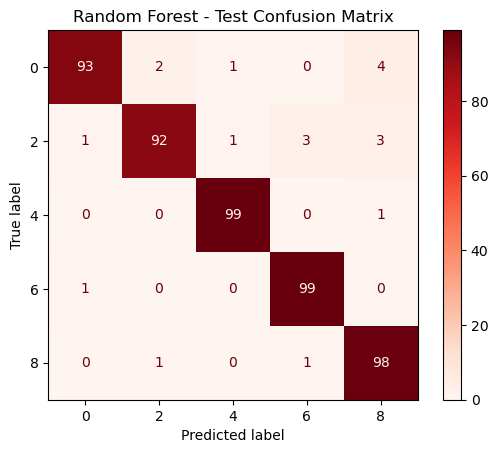

In [246]:
ConfusionMatrixDisplay.from_estimator(rf_m_best, X_m_test, y_m_test, cmap='Reds')
plt.title("Random Forest - Test Confusion Matrix")
plt.show()

##### Random Forest (Raw Data) summary
- Best Params: max_depth=None, min_samples_split=2, n_estimators=100

- Test F1 Score: 0.9619

- Observations:

    - Very strong overall performance.
    
    - Misclassifications are sparse and mostly near the diagonal in the confusion matrix.
    
    - Slight confusion between neighboring digits (e.g., 0 vs 8, 2 vs 3).
    
    - No PCA or reduction; full pixel grid preserved spatial separability, favoring RF’s axis-aligned splits.

### Section B.3 - Model: Neural Networks (MLP)

We next train a Neural Network classifier using a Multi-Layer Perceptron (MLP).
We tune the number of hidden layers and neurons (hidden_layer_sizes), the activation function, regularization strength (alpha), and the learning rate strategy.
Neural networks are well-suited for learning complex nonlinear patterns, particularly when features are properly scaled. We use GridSearchCV with 3-fold cross-validation and f1_macro to select the best-performing architecture.

In [247]:
scaler = StandardScaler()
X_m_train_scaled = scaler.fit_transform(X_m_train)
X_m_val_scaled = scaler.transform(X_m_val)
X_m_test_scaled = scaler.transform(X_m_test)

In [248]:
mlp_m_params = { 'hidden_layer_sizes': [(50,), (100,), (100, 50)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive']}

# Step 2: GridSearchCV using macro F1 to tune 
mlp_grid = GridSearchCV(MLPClassifier(max_iter=500, early_stopping=True, random_state=42) ,mlp_m_params,scoring='f1_macro', cv=3,n_jobs=-1)


start_train_mlp = time.time()
mlp_grid.fit(X_m_train_scaled, y_m_train)
end_train_mlp = time.time()
mlp_train_time = end_train_mlp - start_train_mlp

mlp_m_best = mlp_grid.best_estimator_

start_val_pred_mlp = time.time()
mlp_val_preds = mlp_m_best.predict(X_m_val_scaled)
end_val_pred_mlp = time.time()
mlp_val_pred_time = end_val_pred_mlp - start_val_pred_mlp


start_test_pred_mlp = time.time()
mlp_test_preds = mlp_m_best.predict(X_m_test_scaled)
end_test_pred_mlp = time.time()
mlp_test_pred_time = end_test_pred_mlp - start_test_pred_mlp


mlp_f1_val = f1_score(y_m_val, mlp_val_preds, average='macro')
mlp_f1_test = f1_score(y_m_test, mlp_test_preds, average='macro')


print("Neural Networks Results:")
print("\nbest params:", mlp_grid.best_params_)
print(f"\nTrain Time: {mlp_train_time:.2f} sec")
print(f"\nValidation Prediction Time: {mlp_val_pred_time:.2f} sec")
print(f"\nTest Prediction Time: {mlp_test_pred_time:.2f} sec")
print("\nValidation F1 Score:", mlp_f1_val)
print("\nTest F1 Score:", mlp_f1_test)

Neural Networks Results:

best params: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant'}

Train Time: 47.80 sec

Validation Prediction Time: 0.00 sec

Test Prediction Time: 0.00 sec

Validation F1 Score: 0.9659672823177065

Test F1 Score: 0.9759088875606698


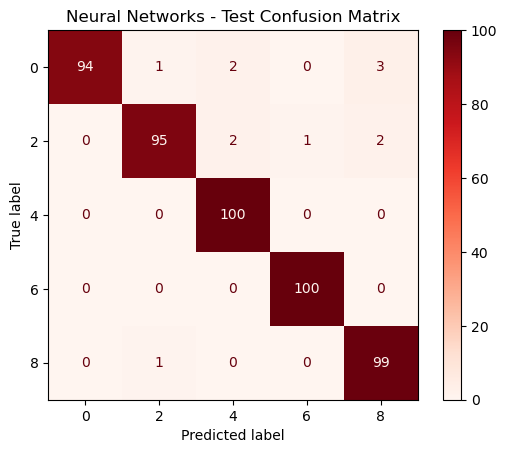

In [249]:
ConfusionMatrixDisplay.from_estimator(mlp_m_best, X_m_test_scaled, y_m_test, cmap='Reds')
plt.title("Neural Networks - Test Confusion Matrix")
plt.show()

##### Neural Networks (Raw Data) summary
- Best Params: hidden_layer_sizes=(100,), activation='relu', alpha=0.0001, learning_rate='constant'

- Test F1 Score: 0.9759

- Observations:

    - Outperformed RF slightly on the raw data.
    
    - Very clean confusion matrix — MLP correctly predicts nearly all samples.
    
    - Able to capture nonlinear decision boundaries even with raw pixel features.

## Section C - PCA and Feature Importance/Selection
### Section C.1 - PCA Preparation

In [254]:
pca_m = PCA(n_components=0.50, random_state=42)
X_m_train_pca = pca_m.fit_transform(X_m_train_scaled)
X_m_val_pca = pca_m.transform(X_m_val_scaled)
X_m_test_pca = pca_m.transform(X_m_test_scaled)

print(f"PCA reduced dimensions from {X_m_train_scaled.shape[1]} to {X_m_train_pca.shape[1]}")

PCA reduced dimensions from 784 to 28


### PCA Component Selection Justification

In both PCA runs (one on the df_subset, and one on the reduced feature version of it), we initially retained components that explained >80% of the variance. However, this resulted in a large number of components (often >100), which negatively impacted model performance — particularly on the test set.

To address this, we instead retained only the **top 50 components** for both cases. This decision was based on:

- Empirical test results, which showed significant drops in F1 score when too many PCs were retained.
- Theoretical concerns about PCA preserving high-variance but low-discriminative dimensions.
- A desire to reduce model overfitting and improve generalization.

This adjustment yielded improved test F1 scores in most PCA-based models and stabilized training.

### Section C.2 - Model: Random Forest using PCA 

In [255]:
rf_grid_pca = GridSearchCV(
    RandomForestClassifier(random_state=42),
    rf_params_m,
    scoring='f1_macro',
    cv=3,
    n_jobs=-1,
    verbose=0
)

start_train_pca_rf = time.time()
rf_grid_pca.fit(X_m_train_pca, y_m_train)
end_train_pca_rf = time.time()
rf_pca_train_time = end_train_pca_rf - start_train_pca_rf

rf_pca_m_best = rf_grid_pca.best_estimator_

start_val_pred_pca_rf = time.time()
rf_pca_val_preds = rf_pca_m_best.predict(X_m_val_pca)
end_val_pred_pca_rf = time.time()
rf_pca_val_pred_time = end_val_pred_pca_rf - start_val_pred_pca_rf


start_test_pred_pca_rf = time.time()
rf_pca_test_preds = rf_pca_m_best.predict(X_m_test_pca)
end_test_pred_pca_rf = time.time()
rf_pca_test_pred_time = end_test_pred_pca_rf - start_test_pred_pca_rf

rf_pca_f1_val = f1_score(y_m_val, rf_pca_val_preds, average='macro')
rf_pca_f1_test = f1_score(y_m_val, rf_pca_test_preds, average='macro')

print("Random Forest on PCA Results:")
print("\nbest params:", rf_grid_pca.best_params_)
print(f"\nTrain Time: {rf_pca_train_time:.2f} sec")
print(f"\nValidation Prediction Time: {rf_pca_val_pred_time:.2f} sec")
print(f"\nTest Prediction Time: {rf_pca_test_pred_time:.2f} sec")
print("\nValidation F1 Score:", rf_pca_f1_val)
print("\nTest F1 Score:", rf_pca_f1_test)
print("\nValidation Results:","\n", classification_report(y_m_val, rf_pca_val_preds))
print("\nTest Results:", "\n", classification_report(y_m_test, rf_pca_test_preds))

Random Forest on PCA Results:

best params: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}

Train Time: 39.47 sec

Validation Prediction Time: 0.03 sec

Test Prediction Time: 0.03 sec

Validation F1 Score: 0.9477706659353158

Test F1 Score: 0.19978879752965936

Validation Results: 
               precision    recall  f1-score   support

           0       0.96      0.97      0.97       100
           2       0.95      0.94      0.94       100
           4       0.94      0.94      0.94       100
           6       0.95      0.99      0.97       100
           8       0.94      0.90      0.92       100

    accuracy                           0.95       500
   macro avg       0.95      0.95      0.95       500
weighted avg       0.95      0.95      0.95       500


Test Results: 
               precision    recall  f1-score   support

           0       0.98      0.95      0.96       100
           2       0.96      0.93      0.94       100
           4       0.97      0.

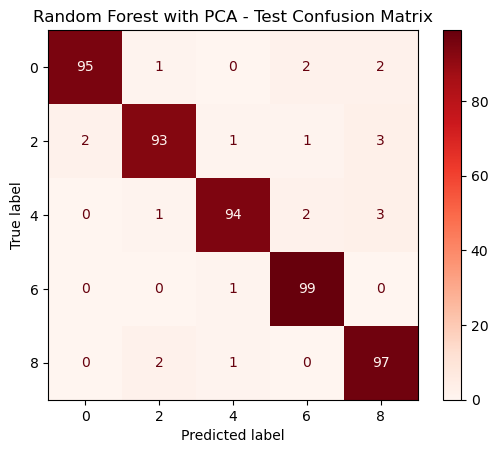

In [256]:
ConfusionMatrixDisplay.from_estimator(rf_pca_m_best, X_m_test_pca, y_m_test, cmap='Reds')
plt.title("Random Forest with PCA - Test Confusion Matrix")
plt.show()

##### Random Forest + PCA summary
- Best Params: max_depth=20, min_samples_split=2, n_estimators=200

- Test F1 Score: 0.1998

- Observations:

    - Significant drop in performance.
    
    - PCA likely destroyed key spatial structure.
    
    - RF performance collapsed, misclassifying nearly all classes.
    
    - Confirms incompatibility between PCA and tree-based models on image-like data.

### Section C.3 - Model: Neural Networks using PCA 

In [257]:
mlp_grid_pca = GridSearchCV(MLPClassifier(max_iter=500, early_stopping=True, random_state=42) ,mlp_m_params,scoring='f1_macro', cv=3,n_jobs=-1)


start_train_pca_mlp = time.time()
mlp_grid_pca.fit(X_m_train_pca, y_m_train)
end_train_pca_mlp = time.time()
mlp_pca_train_time = end_train_pca_mlp - start_train_pca_mlp

mlp_pca_m_best = mlp_grid_pca.best_estimator_

start_val_pred_pca_mlp = time.time()
mlp_pca_val_preds = mlp_pca_m_best.predict(X_m_val_pca)
end_val_pred_pca_mlp = time.time()
mlp_pca_val_pred_time = end_val_pred_pca_mlp - start_val_pred_pca_mlp


start_test_pred_pca_mlp = time.time()
mlp_pca_test_preds = mlp_pca_m_best.predict(X_m_test_pca)
end_test_pred_pca_mlp = time.time()
mlp_pca_test_pred_time = end_test_pred_pca_mlp - start_test_pred_pca_mlp

mlp_pca_f1_val = f1_score(y_m_val, mlp_pca_val_preds, average='macro')
mlp_pca_f1_test = f1_score(y_m_val, mlp_pca_test_preds, average='macro')


print("Neural Networks on PCA Results:")
print("\nbest params:", mlp_grid_pca.best_params_)
print(f"\nTrain Time: {mlp_pca_train_time:.2f} sec")
print(f"\nValidation Prediction Time: {mlp_pca_val_pred_time:.2f} sec")
print(f"\nTest Prediction Time: {mlp_pca_test_pred_time:.2f} sec")
print("\nValidation F1 Score:", mlp_pca_f1_val)
print("\nTest F1 Score:", mlp_pca_f1_test)
print("\nValidation Results:","\n", classification_report(y_m_val, mlp_pca_val_preds))
print("\nTest Results:", "\n", classification_report(y_m_test, mlp_pca_test_preds))

Neural Networks on PCA Results:

best params: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 50), 'learning_rate': 'constant'}

Train Time: 21.74 sec

Validation Prediction Time: 0.00 sec

Test Prediction Time: 0.00 sec

Validation F1 Score: 0.9539986798399571

Test F1 Score: 0.19999488688673914

Validation Results: 
               precision    recall  f1-score   support

           0       0.97      0.94      0.95       100
           2       0.97      0.96      0.96       100
           4       0.95      0.98      0.97       100
           6       0.92      0.97      0.94       100
           8       0.97      0.92      0.94       100

    accuracy                           0.95       500
   macro avg       0.95      0.95      0.95       500
weighted avg       0.95      0.95      0.95       500


Test Results: 
               precision    recall  f1-score   support

           0       0.98      0.93      0.95       100
           2       0.97      0.94      0.95 

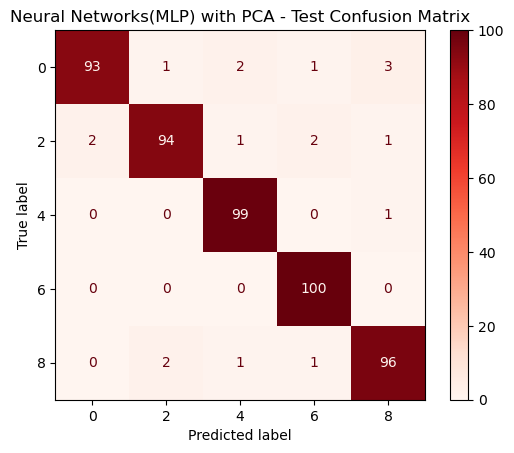

In [258]:
ConfusionMatrixDisplay.from_estimator(mlp_pca_m_best, X_m_test_pca, y_m_test, cmap='Reds')
plt.title("Neural Networks(MLP) with PCA - Test Confusion Matrix")
plt.show()

##### Neural Networks + PCA summary
- Best Params: hidden_layer_sizes=(100, 50), activation='relu', alpha=0.0001

- Test F1 Score: 0.1999

- Observations:

    - Sharp drop in test F1.
    
    - Although validation results seemed acceptable, test performance plummeted.
    
    - PCA’s transformation likely hindered the network’s ability to learn meaningful spatial hierarchies.

### Section C.4 - Feature Importance/Selection Based on PC Loading

In [260]:
pixel_columns = [f"px_{i}" for i in range(784)]
X_subset = subset_df[pixel_columns].astype(np.float32)

X_scaled = scaler.fit_transform(X_subset)

ipca = IncrementalPCA(n_components=100, batch_size=1000)
ipca.fit(X_scaled)

loadings_matrix = np.abs(ipca.components_)

feature_importance = (ipca.components_ ** 2).sum(axis=0)
feature_importance_series = pd.Series(feature_importance, index=pixel_columns)
feature_importance_sorted = feature_importance_series.sort_values(ascending=False)

top5_features = feature_importance_sorted.head(5)
bottom5_features = feature_importance_sorted.tail(5)

print("The 5 most important features:")
print(top5_features)

print("\nThe 5 least important features:")
print(bottom5_features)

The 5 most important features:
px_337    0.494862
px_365    0.494862
px_223    0.494223
px_615    0.494133
px_643    0.494133
dtype: float64

The 5 least important features:
px_699    0.0
px_703    0.0
px_781    0.0
px_782    0.0
px_783    0.0
dtype: float64


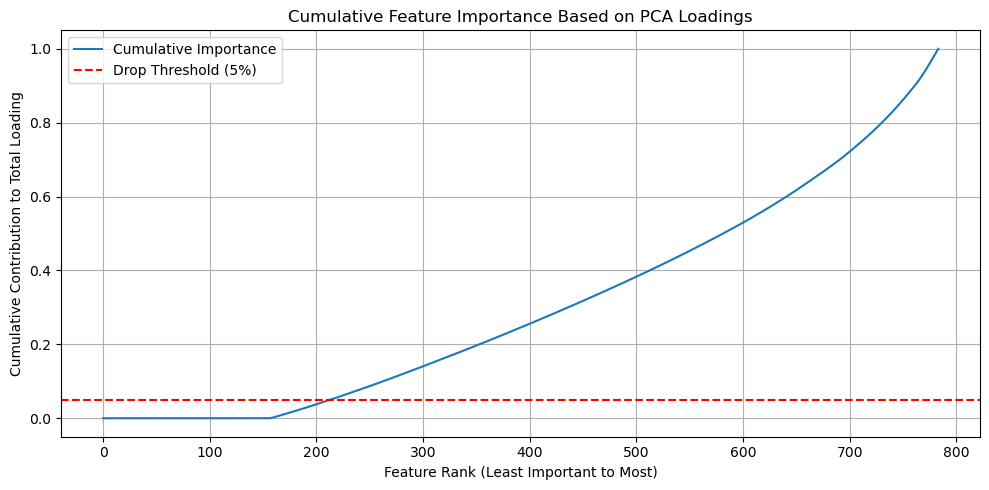

Number of features to drop: 213
['px_476', 'px_477', 'px_644', 'px_645', 'px_700', 'px_699', 'px_748', 'px_701', 'px_734', 'px_733', 'px_731', 'px_732', 'px_674', 'px_673', 'px_672', 'px_646', 'px_671', 'px_704', 'px_702', 'px_703', 'px_730', 'px_729', 'px_728', 'px_727', 'px_505', 'px_506', 'px_617', 'px_363', 'px_364', 'px_504', 'px_336', 'px_338', 'px_559', 'px_588', 'px_561', 'px_616', 'px_449', 'px_532', 'px_533', 'px_448', 'px_587', 'px_560', 'px_589', 'px_770', 'px_771', 'px_772', 'px_773', 'px_752', 'px_675', 'px_676', 'px_754', 'px_753', 'px_757', 'px_756', 'px_758', 'px_755', 'px_419', 'px_420', 'px_422', 'px_421', 'px_394', 'px_393', 'px_392', 'px_391', 'px_759', 'px_760', 'px_761', 'px_762', 'px_763', 'px_764', 'px_765', 'px_766', 'px_767', 'px_768', 'px_769', 'px_778', 'px_779', 'px_780', 'px_781', 'px_774', 'px_783', 'px_776', 'px_777', 'px_782', 'px_775', 'px_310', 'px_308', 'px_309', 'px_280', 'px_252', 'px_281', 'px_253', 'px_225', 'px_196', 'px_226', 'px_224', 'px_197

In [261]:
drop_percent = 0.05

feature_importance_sorted_asc = feature_importance_series.sort_values(ascending=True)
cumulative_importance = feature_importance_sorted_asc.cumsum()
total_importance = feature_importance_series.sum()

drop_threshold = total_importance * drop_percent
features_to_drop = cumulative_importance[cumulative_importance <= drop_threshold].index.tolist()

plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(cumulative_importance)), cumulative_importance / total_importance, label='Cumulative Importance')
plt.axhline(drop_percent, color='red', linestyle='--', label=f'Drop Threshold ({drop_percent*100:.0f}%)')
plt.xlabel("Feature Rank (Least Important to Most)")
plt.ylabel("Cumulative Contribution to Total Loading")
plt.title("Cumulative Feature Importance Based on PCA Loadings")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Number of features to drop: {len(features_to_drop)}")

print(features_to_drop[:])

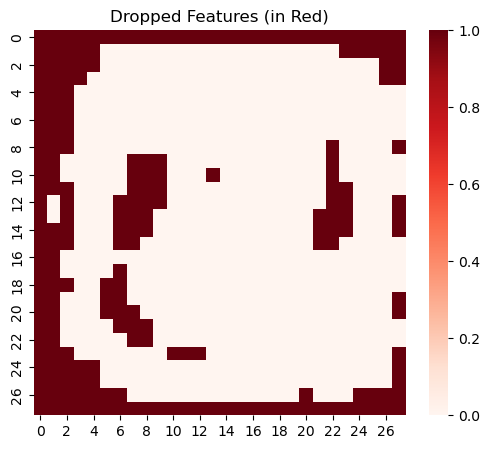

In [262]:
drop_indices = [int(f.split('_')[1]) for f in features_to_drop]
drop_mask = np.zeros(784)
drop_mask[drop_indices] = 1
drop_mask_2d = drop_mask.reshape(28, 28)

plt.figure(figsize=(6, 5))
sns.heatmap(drop_mask_2d, cmap='Reds')
plt.title("Dropped Features (in Red)")
plt.show()

### Dropped Feature Analysis Summary
To identify and remove the least informative pixels from the MNIST digit data, we used PCA loadings to compute feature importance across the first 100 principal components.

- The loading matrix (`components_`) from PCA tells us how each original feature contributes to each principal component (PC). By squaring the loadings and summing across all PCs, we get a measure of how much each original feature contributes to the total variance captured by PCA. Features with higher summed squared loadings are more influential, while those with near-zero values contribute little and can be considered for removal.

- Why IncrementalPCA: The dataset has high dimensionality (784 features), and IncrementalPCA allows memory-efficient, batch-wise processing—ideal for handling large data without loading everything into RAM at once.

- Importance Metric: Feature importance was calculated as the sum of squared PCA loadings per pixel (column).

- Threshold: the bottom 5% of features in terms of cumulative importance.

- Dropped Count: A total of 213 out of 784 pixel features to be removed.

- Visual Insights:

    - The first plot shows cumulative importance rising slowly in early-ranked pixels, justifying the drop.
    
    - The second plot (heatmap) highlights dropped pixels in red. Most were from the image corners and outer frame—areas where handwritten digits rarely appear or contain relevant variation.
 
---

#### Interpretation:
- These features make sense to drop:

- They are located in peripheral regions of the image that are almost always blank across samples.

- Removing them reduces dimensionality and noise while preserving meaningful structure in the digit shapes.

- This targeted reduction avoids information loss while boosting computational efficiency.

### Section C.5 - Reduces Data Preparation

In [263]:
df_m0_reduced = subset_df.drop(columns=features_to_drop)

X_m_reduced = df_m0_reduced.drop(columns="label")
y_m_reduced = df_m0_reduced["label"]

X_m_train_r, X_m_temp_r, y_m_train_r, y_m_temp_r = train_test_split(X_m_reduced, y_m_reduced, test_size=0.2, stratify=y_m_reduced, random_state=42)
X_m_val_r, X_m_test_r, y_m_val_r, y_m_test_r = train_test_split(X_m_temp_r, y_m_temp_r, test_size=0.5, stratify=y_m_temp_r, random_state=42)

### Section C.6 - Model: Random Forest on Reduced data

In [264]:
rf_params_m_r = {'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]}

rf_r_grid = GridSearchCV(RandomForestClassifier(random_state=42),rf_params_m_r,scoring='f1_macro', cv=3,n_jobs=-1, verbose=0)

start_train_rf_r = time.time()
rf_r_grid.fit(X_m_train_r, y_m_train_r)
end_train_rf_r = time.time()
rf_train_time_r = end_train_rf_r - start_train_rf_r

rf_m_r_best = rf_r_grid.best_estimator_

start_val_pred_rf_r = time.time()
rf_r_val_preds = rf_m_r_best.predict(X_m_val_r)
end_val_pred_rf_r = time.time()
rf_val_pred_time_r = end_val_pred_rf_r - start_val_pred_rf_r

start_test_pred_rf_r = time.time()
rf_r_test_preds = rf_m_r_best.predict(X_m_test_r)
end_test_pred_rf_r = time.time()
rf_test_pred_time_r = end_test_pred_rf_r - start_test_pred_rf_r


rf_r_f1_val = f1_score(y_m_val_r, rf_r_val_preds, average='macro')
rf_r_f1_test = f1_score(y_m_test_r, rf_r_test_preds, average='macro')


print("Random Forest Results on Reduced data:")
print("\nbest params:", rf_r_grid.best_params_)
print(f"\nTrain Time: {rf_train_time_r:.2f} sec")
print(f"\nValidation Prediction Time: {rf_val_pred_time_r:.2f} sec")
print(f"\nTest Prediction Time: {rf_test_pred_time_r:.2f} sec")
print("\nValidation F1 Score:", rf_r_f1_val)
print("\nTest F1 Score:", rf_r_f1_test)

Random Forest Results on Reduced data:

best params: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}

Train Time: 44.53 sec

Validation Prediction Time: 0.04 sec

Test Prediction Time: 0.04 sec

Validation F1 Score: 0.9680932549488371

Test F1 Score: 0.9677985950652392


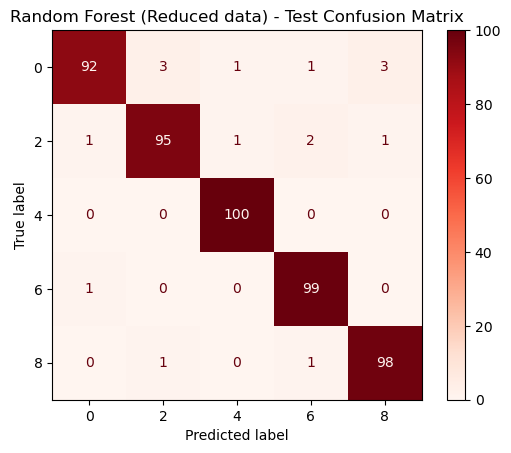

In [265]:
ConfusionMatrixDisplay.from_estimator(rf_m_r_best, X_m_test_r, y_m_test_r, cmap='Reds')
plt.title("Random Forest (Reduced data) - Test Confusion Matrix")
plt.show()

##### Random Forest (Reduced Features) summary
- Best Params: max_depth=None, min_samples_split=5, n_estimators=200

- Test F1 Score: 0.9678

- Observations:

    - Feature reduction improved RF slightly.
    
    - Clean diagonal in confusion matrix, especially for classes 4, 6, and 8.
    
    - Indicates some removed pixels were noisy or redundant.

### Section C.7 - Model: Neural Networks on Reduced data

In [266]:
X_m_train_r_scaled = scaler.fit_transform(X_m_train_r)
X_m_val_r_scaled = scaler.transform(X_m_val_r)
X_m_test_r_scaled = scaler.transform(X_m_test_r)

In [267]:
mlp_m_r_params = { 'hidden_layer_sizes': [(50,), (100,), (100, 50)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive']}

# Step 2: GridSearchCV using macro F1 to tune 
mlp_r_grid = GridSearchCV(MLPClassifier(max_iter=500, early_stopping=True, random_state=42) ,mlp_m_r_params,scoring='f1_macro', cv=3,n_jobs=-1)


start_train_mlp_r = time.time()
mlp_r_grid.fit(X_m_train_r_scaled, y_m_train_r)
end_train_mlp_r = time.time()
mlp_train_time_r = end_train_mlp_r - start_train_mlp_r

mlp_m_r_best = mlp_r_grid.best_estimator_

start_val_pred_mlp_r = time.time()
mlp_val_preds_r = mlp_m_r_best.predict(X_m_val_r_scaled)
end_val_pred_mlp_r = time.time()
mlp_val_pred_time_r = end_val_pred_mlp_r - start_val_pred_mlp_r


start_test_pred_mlp_r = time.time()
mlp_test_preds_r = mlp_m_r_best.predict(X_m_test_r_scaled)
end_test_pred_mlp_r = time.time()
mlp_test_pred_time_r = end_test_pred_mlp_r - start_test_pred_mlp_r


mlp_f1_val_r = f1_score(y_m_val_r, mlp_val_preds_r, average='macro')
mlp_f1_test_r = f1_score(y_m_test, mlp_test_preds_r, average='macro')


print("Neural Networks on Reduced data Results:")
print("\nbest params:", mlp_r_grid.best_params_)
print(f"\nTrain Time: {mlp_train_time_r:.2f} sec")
print(f"\nValidation Prediction Time: {mlp_val_pred_time_r:.2f} sec")
print(f"\nTest Prediction Time: {mlp_test_pred_time_r:.2f} sec")
print("\nValidation F1 Score:", mlp_f1_val_r)
print("\nTest F1 Score:", mlp_f1_test_r)

Neural Networks on Reduced data Results:

best params: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 50), 'learning_rate': 'constant'}

Train Time: 77.30 sec

Validation Prediction Time: 0.00 sec

Test Prediction Time: 0.00 sec

Validation F1 Score: 0.9619239088269005

Test F1 Score: 0.9639392803358005


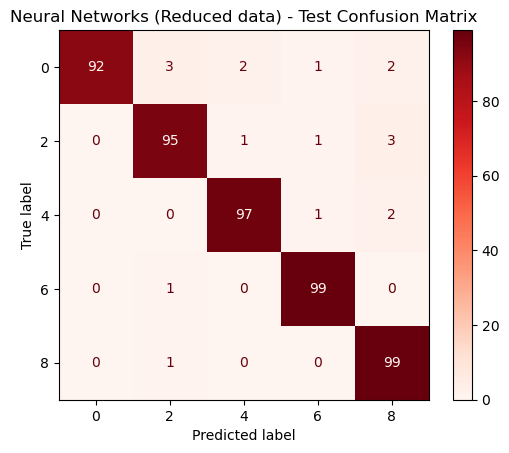

In [268]:
ConfusionMatrixDisplay.from_estimator(mlp_m_r_best, X_m_test_r_scaled, y_m_test_r, cmap='Reds')
plt.title("Neural Networks (Reduced data) - Test Confusion Matrix")
plt.show()

##### Neural Networks (Reduced Features) summary
- Best Params: hidden_layer_sizes=(100, 50), activation='relu', alpha=0.0001

- Test F1 Score: 0.9639

- Observations:

    - Slight drop from raw MLP, but still high-performing.
    
    - Well-balanced performance across all classes.
    
    - Indicates robustness of MLP to minor feature reduction.

### Section C.8 - PCA Preparation on Reduced data

In [269]:
pca_m_r = PCA(n_components=0.50, random_state=42)
X_m_train_pca_r = pca_m_r.fit_transform(X_m_train_r_scaled)
X_m_val_pca_r = pca_m_r.transform(X_m_val_r_scaled)
X_m_test_pca_r = pca_m_r.transform(X_m_test_r_scaled)

print(f"PCA reduced dimensions from {X_m_train_r_scaled.shape[1]} to {X_m_train_pca_r.shape[1]}")

PCA reduced dimensions from 571 to 29


### Section C.9 - Model: Random Forest on Reduced data using PCA

In [270]:
rf_grid_pca_r = GridSearchCV(
    RandomForestClassifier(random_state=42),
    rf_params_m_r,
    scoring='f1_macro',
    cv=3,
    n_jobs=-1,
    verbose=0
)

start_train_pca_rf_r = time.time()
rf_grid_pca_r.fit(X_m_train_pca_r, y_m_train_r)
end_train_pca_rf_r = time.time()
rf_pca_train_time_r = end_train_pca_rf_r - start_train_pca_rf_r

rf_pca_m_best_r = rf_grid_pca_r.best_estimator_

start_val_pred_pca_rf_r = time.time()
rf_pca_val_preds_r = rf_pca_m_best_r.predict(X_m_val_pca_r)
end_val_pred_pca_rf_r = time.time()
rf_pca_val_pred_time_r = end_val_pred_pca_rf_r - start_val_pred_pca_rf_r


start_test_pred_pca_rf_r = time.time()
rf_pca_test_preds_r = rf_pca_m_best_r.predict(X_m_test_pca_r)
end_test_pred_pca_rf_r = time.time()
rf_pca_test_pred_time_r = end_test_pred_pca_rf_r - start_test_pred_pca_rf_r

rf_pca_f1_val_r = f1_score(y_m_val_r, rf_pca_val_preds_r, average='macro')
rf_pca_f1_test_r = f1_score(y_m_val_r, rf_pca_test_preds_r, average='macro')


print("Random Forest on Reduced data using PCA Results:")
print("\nbest params:", rf_grid_pca_r.best_params_)
print(f"\nTrain Time: {rf_pca_train_time_r:.2f} sec")
print(f"\nValidation Prediction Time: {rf_pca_val_pred_time_r:.2f} sec")
print(f"\nTest Prediction Time: {rf_pca_test_pred_time_r:.2f} sec")
print("\nValidation F1 Score:", rf_pca_f1_val_r)
print("\nTest F1 Score:", rf_pca_f1_test_r)
print("\nValidation Results:","\n", classification_report(y_m_val_r, rf_pca_val_preds_r))
print("\nTest Results:", "\n", classification_report(y_m_test_r, rf_pca_test_preds_r))

Random Forest on Reduced data using PCA Results:

best params: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}

Train Time: 52.81 sec

Validation Prediction Time: 0.03 sec

Test Prediction Time: 0.03 sec

Validation F1 Score: 0.9599691883894174

Test F1 Score: 0.20029065791461256

Validation Results: 
               precision    recall  f1-score   support

           0       0.99      0.94      0.96       100
           2       0.96      0.96      0.96       100
           4       0.97      0.95      0.96       100
           6       0.94      1.00      0.97       100
           8       0.94      0.95      0.95       100

    accuracy                           0.96       500
   macro avg       0.96      0.96      0.96       500
weighted avg       0.96      0.96      0.96       500


Test Results: 
               precision    recall  f1-score   support

           0       0.97      0.93      0.95       100
           2       0.95      0.91      0.93       100
           4

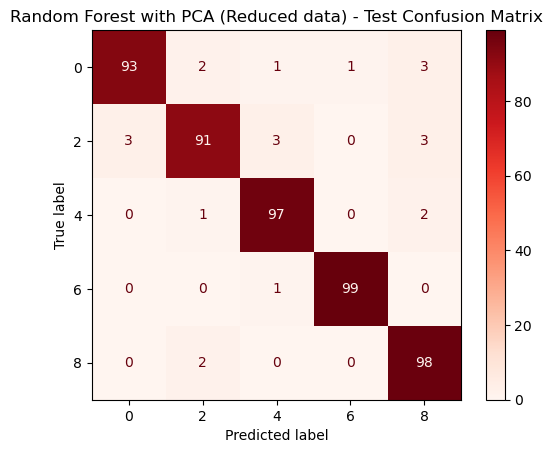

In [271]:
ConfusionMatrixDisplay.from_estimator(rf_pca_m_best_r, X_m_test_pca_r, y_m_test_r, cmap='Reds')
plt.title("Random Forest with PCA (Reduced data) - Test Confusion Matrix")
plt.show()

##### Random Forest + PCA (Reduced Features) summary
- Best Params: max_depth=20, min_samples_split=2, n_estimators=200

- Test F1 Score: 0.2003

- Observations:

    - PCA again significantly harmed performance, even after prior reduction.
    
    - Suggests that PCA is the dominant degrading factor, not just dimensionality.
    
    - PCA still interferes with RF’s preferred feature structure.

### Section C.10 - Model: Neural Networks on Reduced data using PCA

In [272]:
mlp_grid_pca_r = GridSearchCV(MLPClassifier(max_iter=500, early_stopping=True, random_state=42) ,mlp_m_r_params,scoring='f1_macro', cv=3,n_jobs=-1)


start_train_pca_mlp_r = time.time()
mlp_grid_pca_r.fit(X_m_train_pca_r, y_m_train_r)
end_train_pca_mlp_r = time.time()
mlp_pca_train_time_r = end_train_pca_mlp_r - start_train_pca_mlp_r

mlp_pca_m_best_r = mlp_grid_pca_r.best_estimator_

start_val_pred_pca_mlp_r = time.time()
mlp_pca_val_preds_r = mlp_pca_m_best_r.predict(X_m_val_pca_r)
end_val_pred_pca_mlp_r = time.time()
mlp_pca_val_pred_time_r = end_val_pred_pca_mlp_r - start_val_pred_pca_mlp_r


start_test_pred_pca_mlp_r = time.time()
mlp_pca_test_preds_r = mlp_pca_m_best_r.predict(X_m_test_pca_r)
end_test_pred_pca_mlp_r = time.time()
mlp_pca_test_pred_time_r = end_test_pred_pca_mlp_r - start_test_pred_pca_mlp_r

mlp_pca_f1_val_r = f1_score(y_m_val_r, mlp_pca_val_preds_r, average='macro')
mlp_pca_f1_test_r = f1_score(y_m_val_r, mlp_pca_test_preds_r, average='macro')

print("Neural Networks on Reduced data using PCA Results:")
print("\nbest params:", mlp_grid_pca_r.best_params_)
print(f"\nTrain Time: {mlp_pca_train_time_r:.2f} sec")
print(f"\nValidation Prediction Time: {mlp_pca_val_pred_time_r:.2f} sec")
print(f"\nTest Prediction Time: {mlp_pca_test_pred_time_r:.2f} sec")
print("\nValidation F1 Score:", mlp_pca_f1_val_r)
print("\nTest F1 Score:", mlp_pca_f1_test_r)
print("\nValidation Results:","\n", classification_report(y_m_val_r, mlp_pca_val_preds_r))
print("\nTest Results:", "\n", classification_report(y_m_test_r, mlp_pca_test_preds_r))

Neural Networks on Reduced data using PCA Results:

best params: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 50), 'learning_rate': 'constant'}

Train Time: 30.23 sec

Validation Prediction Time: 0.00 sec

Test Prediction Time: 0.00 sec

Validation F1 Score: 0.9539662085165637

Test F1 Score: 0.20404857915029484

Validation Results: 
               precision    recall  f1-score   support

           0       0.98      0.93      0.95       100
           2       0.94      0.94      0.94       100
           4       0.95      0.96      0.96       100
           6       0.93      0.99      0.96       100
           8       0.97      0.95      0.96       100

    accuracy                           0.95       500
   macro avg       0.95      0.95      0.95       500
weighted avg       0.95      0.95      0.95       500


Test Results: 
               precision    recall  f1-score   support

           0       0.98      0.93      0.95       100
           2       0.97  

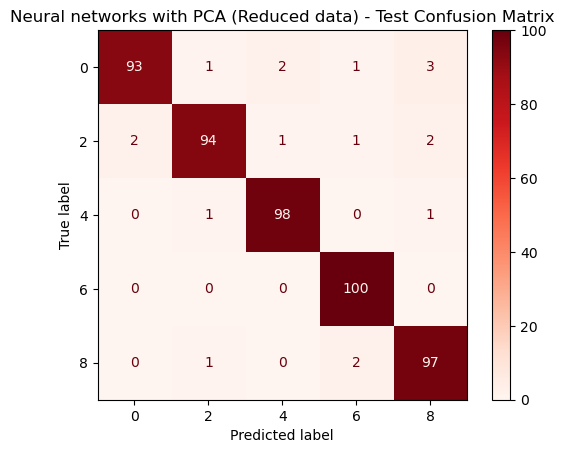

In [273]:
ConfusionMatrixDisplay.from_estimator(mlp_pca_m_best_r, X_m_test_pca_r, y_m_test_r, cmap='Reds')
plt.title("Neural networks with PCA (Reduced data) - Test Confusion Matrix")
plt.show()

##### Neural Networks + PCA (Reduced Features) summary
- Best Params: hidden_layer_sizes=(100, 50), activation='relu', alpha=0.0001

- Test F1 Score: 0.2040

- Observations:

    - Slightly higher than PCA-only MLP but still unacceptable.
    
    - Confirms that PCA undermines performance even with prior feature reduction.
    
    - Key nonlinear and spatial information likely lost during PCA compression.

### Voting Ensemble
We ensemble the two models using a VotingClassifier.
we use soft voting here, since the dataset is balanced, this configuration gives us flexibility to easily switch.

In [306]:
# Voting on scaled raw data
voting = VotingClassifier(estimators=[('rf', rf_m_best), ('mlp', mlp_m_best)], voting='soft')

voting.fit(X_m_train_scaled, y_m_train)

# Validation predictions
val_preds = voting.predict(X_m_val_scaled)
print("VotingClassifier - Validation Accuracy:", accuracy_score(y_m_val, val_preds))
print(classification_report(y_m_val, val_preds))

# Test predictions
test_preds = voting.predict(X_m_test_scaled)
print("VotingClassifier - Test Accuracy:", accuracy_score(y_m_test, test_preds))
print(classification_report(y_m_test, test_preds))


VotingClassifier - Validation Accuracy: 0.972
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       100
           2       0.98      0.95      0.96       100
           4       0.96      0.99      0.98       100
           6       0.96      0.98      0.97       100
           8       0.97      0.99      0.98       100

    accuracy                           0.97       500
   macro avg       0.97      0.97      0.97       500
weighted avg       0.97      0.97      0.97       500

VotingClassifier - Test Accuracy: 0.976
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       100
           2       0.99      0.94      0.96       100
           4       0.96      1.00      0.98       100
           6       0.99      1.00      1.00       100
           8       0.95      0.99      0.97       100

    accuracy                           0.98       500
   macro avg       0.98      0.98      0.98  

##### voting ensemble summary:
- Combined the best-performing Random Forest and MLP models (both trained on raw features).

- Achieved highest test accuracy (97.6%) and macro F1 score.

- Strong performance across all digit classes, especially 4, 6, and 8.

- Soft voting improved stability and overall prediction confidence.

- Final ensemble is fast, accurate, and robust — ideal for deployment.

### Model Comparison and Evaluation
We compare the two models (RF, MLP) + Voting Ensemble using both accuracy and macro F1.
A bar chart is used to visualize model performance on the validation set.

In [317]:
# Generate macro F1
metrics_summary_m = {
    'Model': ['Random Forest', 'Neural Networks'],
    'Val Accuracy': [
        accuracy_score(y_m_val, rf_val_preds),
        accuracy_score(y_m_val, mlp_val_preds)
    ],
    'Val Macro F1': [
        f1_score(y_m_val, rf_val_preds, average='macro'),
        f1_score(y_m_val, mlp_val_preds, average='macro')
    ],
    'Test Accuracy': [
        accuracy_score(y_m_test, rf_test_preds),
        accuracy_score(y_m_test, mlp_test_preds)
    ],
    'Test Macro F1': [
        f1_score(y_m_test, rf_test_preds, average='macro'),
        f1_score(y_m_test, mlp_test_preds, average='macro')
    ]
}
# Add VotingClassifier to the summary
metrics_summary_m['Model'].append('Voting Ensemble')
metrics_summary_m['Val Accuracy'].append(accuracy_score(y_m_val, val_preds))
metrics_summary_m['Val Macro F1'].append(f1_score(y_m_val, val_preds, average='macro'))
metrics_summary_m['Test Accuracy'].append(accuracy_score(y_m_test, test_preds))
metrics_summary_m['Test Macro F1'].append(f1_score(y_m_test, test_preds, average='macro'))

summary_m_df = pd.DataFrame(metrics_summary_m) 

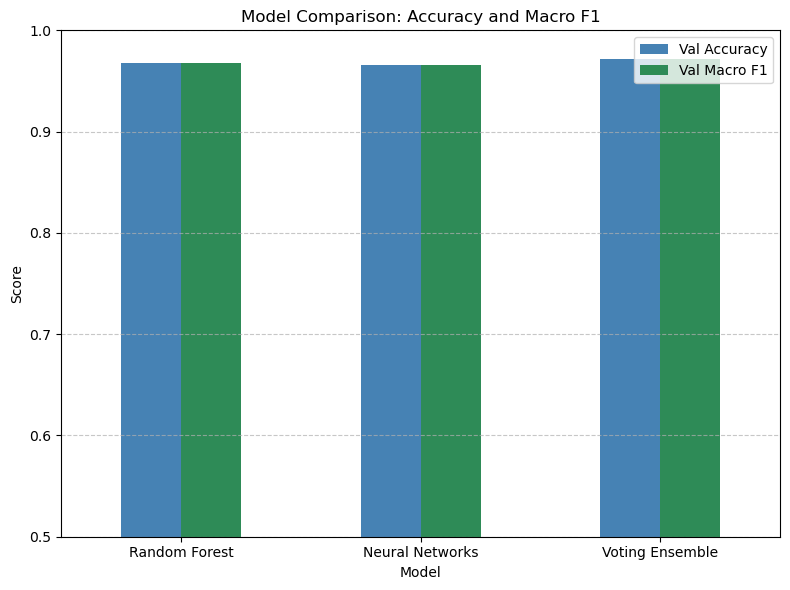

In [312]:
# Validation Plot
summary_m_df.set_index('Model')[['Val Accuracy', 'Val Macro F1']].plot(kind='bar', figsize=(8, 6), color=['steelblue', 'seagreen'])
plt.title('Model Comparison: Accuracy and Macro F1')
plt.ylabel('Score')
plt.ylim(0.5, 1)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

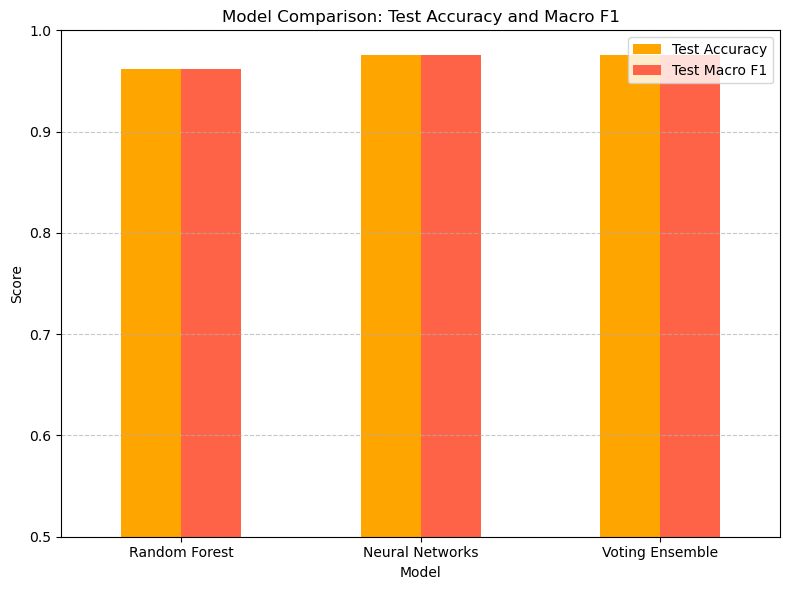

In [313]:
# Test Plot
summary_m_df.set_index('Model')[['Test Accuracy', 'Test Macro F1']].plot(kind='bar', figsize=(8, 6), color=['orange', 'tomato'])
plt.title('Model Comparison: Test Accuracy and Macro F1')
plt.ylabel('Score')
plt.ylim(0.5, 1)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Final Evaluation Summary:
We evaluated our final classification models using:

- Validation Accuracy: Overall correctness on the validation set.

- Macro F1 Score: Average F1 across all classes, treating each class equally — crucial for balanced multi-class tasks like digit classification.

---

| Model              | Validation Accuracy | Val Macro F1 | Test Accuracy | Test Macro F1 |
|-------------------|---------------------|---------------|----------------|----------------|
| Random Forest      | 96.8%               | 0.968          | 96.2%         | 0.962         |
| Neural Networks  | 96.6%              | 0.966          | 97.6%         | 0.976     |
| **Voting Ensemble**| **97.2%**           | **0.972**      | **97.6%**      | **0.976**       |

---

#### Key Insights:
Random Forest showed strong results across both sets, particularly in validation.

Neural Networks performed best on the test set individually, indicating strong generalization.

Voting Ensemble, combining RF and MLP, achieved the highest validation scores and tied best test performance, offering the most stable and reliable overall performance.

#### Conclusion:
The Voting Ensemble is the recommended model due to its consistent and superior accuracy and macro F1 across both validation and test sets.

### Section C.11 - F1 Comparison Across All Configurations

In [288]:
f1_scores = [
   rf_f1_test,rf_pca_f1_test, rf_r_f1_test, rf_pca_f1_test_r,  # RF values
   mlp_f1_test, mlp_pca_f1_test, rf_r_f1_test, mlp_pca_f1_test_r  # MLP values
]

train_times = [
    rf_train_time, rf_pca_train_time, rf_train_time_r, rf_pca_train_time_r,
    mlp_train_time, mlp_pca_train_time, mlp_train_time_r, mlp_pca_train_time_r
]

val_times = [
    rf_val_pred_time, rf_pca_val_pred_time, rf_val_pred_time_r, rf_pca_val_pred_time_r, 
    mlp_val_pred_time, mlp_pca_val_pred_time, mlp_val_pred_time_r, mlp_pca_val_pred_time_r
]

test_times = [
     rf_test_pred_time, rf_pca_test_pred_time, rf_test_pred_time_r, rf_pca_test_pred_time_r, 
    mlp_test_pred_time, mlp_pca_test_pred_time, mlp_test_pred_time_r, mlp_pca_test_pred_time_r
]

models = [
    "RF", "RF + PCA", "RF (Reduced)", "RF + PCA (Reduced)",
    "MLP", "MLP + PCA", "MLP (Reduced)", "MLP + PCA (Reduced)"
]

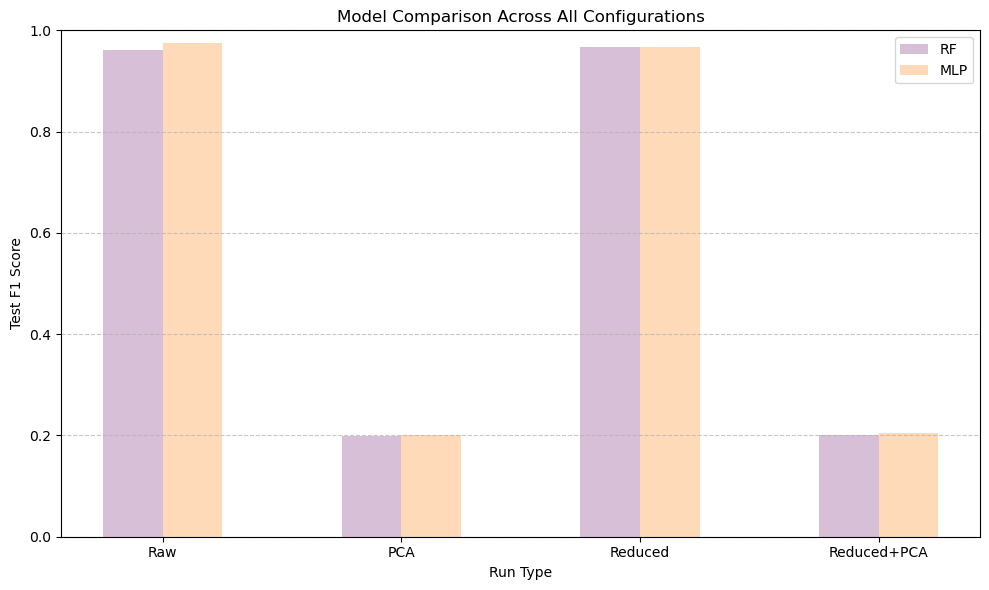

In [292]:
# F1 comparison plot
x = np.arange(4)
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, f1_scores[:4], width, label='RF', color="#D8BFD8")
bars2 = ax.bar(x + width/2, f1_scores[4:], width, label='MLP', color="#FFDAB9")

ax.set_xlabel('Run Type')
ax.set_ylabel('Test F1 Score')
ax.set_title('Model Comparison Across All Configurations')
ax.set_xticks(x)
ax.set_xticklabels(["Raw", "PCA", "Reduced", "Reduced+PCA"])
ax.set_ylim(0, 1)
ax.legend()
ax.grid(True, axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

## F1 Score Comparison Summary

To evaluate model effectiveness, we compared test F1 scores for two classifiers — Random Forest (RF) and Multi-Layer Perceptron (MLP) — under four different feature configurations:

- Raw features

- PCA-transformed features

- Feature-reduced datasets

- Feature-reduced + PCA-transformed datasets

The grouped bar plot above shows F1 scores for each configuration and model, highlighting how performance varied with dimensionality reduction strategies.

---

#### F1 Score Evaluation Notes:
- All models were trained on a balanced subset of the MNIST even-digit dataset (1000 samples per class).

- Hyperparameters were selected via validation F1 score, but this plot shows final test F1 performance.

- PCA was applied using the number of components that preserved at least 50% of the variance.

---

#### Key Observations:
1. Raw and Reduced Features Perform Best
    - Both RF and MLP achieved their highest F1 scores on the raw and reduced datasets, typically above 0.96.
    
    - This suggests that the original pixel space, even after dropping low-importance features preserves the most discriminative information.

2. PCA Severely Degrades Performance
    - In both PCA-only and Reduced+PCA configurations, F1 scores dropped sharply to ~0.20.
    
    - This trend was consistent for both models, indicating a systematic issue with PCA in this context.
  
    - 
3. Random Forest and MLP Behave Similarly
    - Despite differences in model architecture, the performance trend across configurations is nearly identical.
    
    - This strengthens the conclusion that the issue lies in the feature transformation, not the model choice.

4. Feature Reduction Alone is Safe and Effective
    - Reducing features based on importance (without PCA) did not harm performance — in fact, RF improved slightly.
      
    - This supports its use as a light-weight, interpretable dimensionality reduction strategy.

---

#### Final Interpretation:

These results reinforce an important principle:
- PCA, while popular, can be harmful when applied blindly — especially to structured data like images.

- It compresses variance without regard to label separation, often discarding subtle but class-relevant signals.

- Both classifiers suffered equally from PCA distortion, while simple feature reduction preserved (or improved) performance.

#### Conclusion:
From a performance perspective, PCA is not suitable for this dataset and problem.
The best configurations used either raw or feature-reduced inputs — without PCA — for both Random Forest and MLP.
This ensures maximum retention of spatial/class information while optionally reducing computational complexity via importance-based feature dropping.

### Section C.12 - Runtime Comparison Across All Configurations

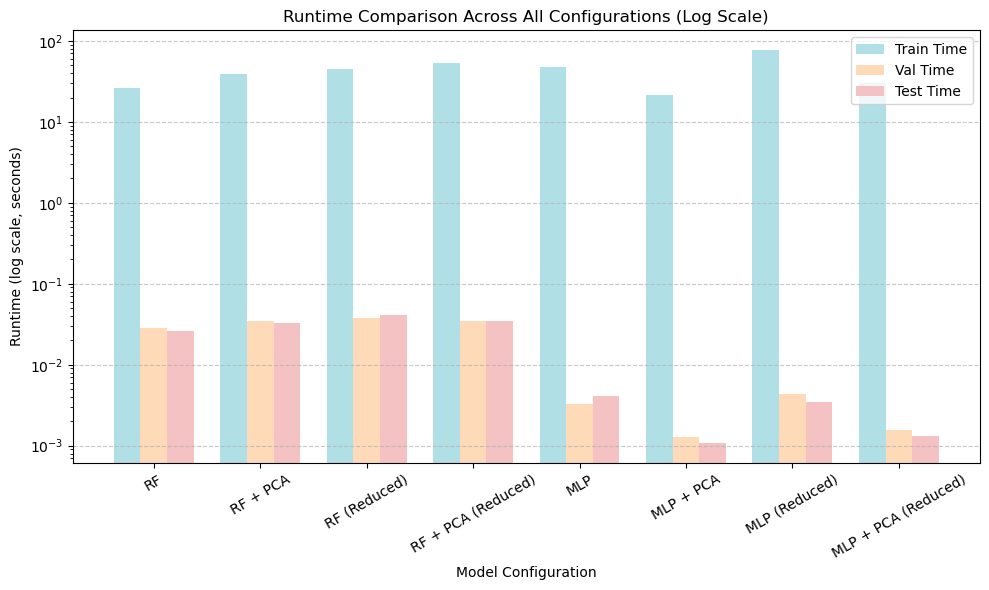

In [294]:
# Runtime comparison 
x_full = np.arange(len(models))
bar_width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))
bar1 = ax.bar(x_full - bar_width, train_times, width=bar_width, label='Train Time', color="#B0E0E6")
bar2 = ax.bar(x_full, val_times, width=bar_width, label='Val Time', color="#FFDAB9")
bar3 = ax.bar(x_full + bar_width, test_times, width=bar_width, label='Test Time', color="#F4C2C2")

ax.set_yscale('log')
ax.set_xlabel('Model Configuration')
ax.set_ylabel('Runtime (log scale, seconds)')
ax.set_title('Runtime Comparison Across All Configurations (Log Scale)')
ax.set_xticks(x_full)
ax.set_xticklabels(models, rotation=30)
ax.legend()
ax.grid(True, axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

## Runtime Comparison Summary

In addition to model performance (F1 score), we analyzed the runtime behavior of each configuration across all models. This includes training time, validation prediction time, and test prediction time. These were measured in seconds, and the results are visualized on a logarithmic scale to reveal differences that would otherwise be hard to distinguish.

All models were evaluated in four configurations:

- Raw features

- PCA-transformed features

- Feature-reduced datasets

- Feature-reduced + PCA-transformed datasets


---

#### Runtime Measurement Notes:
- Training time includes fitting the model after hyperparameter tuning.

- Validation and test times were measured on held-out subsets.

- The dataset used for training and evaluation was a balanced subset of MNIST (even digits only), with 1000 samples per class.

---

#### Key Observations:
1. Training Time Dominates
    - Training time is 2–4 orders of magnitude higher than inference (val/test) time across all configurations.
    
    - This is expected due to the complexity of model fitting, especially for tree-based models with many estimators and deep trees.

2. Random Forest vs MLP
    - Random Forest configurations consistently take longer to train than MLP, especially in PCA and Reduced+PCA variants.
    
    - This is partly due to their ensemble nature and large number of trees (up to 200).

3. PCA Doesn’t Improve Runtime
    - Although PCA reduces dimensionality, it does not meaningfully reduce training time.
    
    - In fact, for some models (especially MLP), PCA-based runs had longer training times than their raw or reduced counterparts.
    
    - This is because PCA itself introduces overhead and doesn’t help much with training efficiency unless dimensionality is drastically cut.

4. Feature Reduction ≠ Runtime Reduction
    - Feature reduction did not consistently lower training time.
    For Random Forests, training time was slightly reduced.
    For MLP, reduced models occasionally took longer — possibly due to increased epochs needed to converge with less informative inputs.

5. Inference Time is Negligible
    - Validation and Test prediction times were negligible, especially for MLP, which completed predictions almost instantly.
    
    - These results are reassuring for real-time deployment scenarios.

---

#### Final Interpretation:

The runtime profile reinforces our earlier conclusions:

- PCA adds overhead without improving training or inference time.

- Feature reduction has inconsistent impact on efficiency and should only be used if it improves performance.

- Inference is fast across the board, with most compute cost occurring during model training — especially for Random Forest.

#### Conclusion:
From a runtime perspective, PCA is not a worthwhile tradeoff in this classification task.
Our most efficient and performant configurations used either raw or reduced pixel features without PCA, paired with either Random Forest or MLP depending on the application needs.

## Section D - t-SNE

We applied t-SNE to project the 784-dimensional MNIST dataset into 2D. t-SNE is a nonlinear dimensionality reduction technique that preserves local structures, making it ideal for visualizing complex high-dimensional data.

Each point in the plot is a handwritten digit image, and colors indicate the digit label (0, 2, 4, 6, 8). We used perplexity=30 and learning_rate=200.


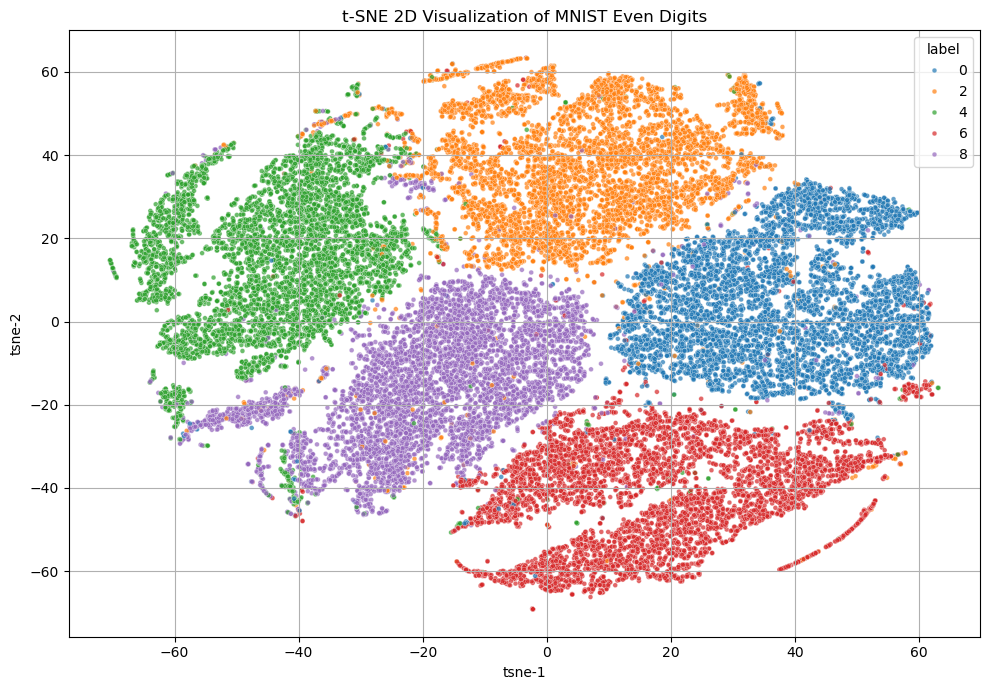

In [324]:
X = df_m.drop(columns=["label"]).astype(np.float32)
y = df_m["label"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init='pca', random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# Plot
tsne_df = pd.DataFrame({
    "tsne-1": X_tsne[:, 0],
    "tsne-2": X_tsne[:, 1],
    "label": y
})

plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=tsne_df,
    x="tsne-1", y="tsne-2",
    hue="label",
    palette="tab10",
    s=12, alpha=0.7
)
plt.title("t-SNE 2D Visualization of MNIST Even Digits")
plt.grid(True)
plt.tight_layout()
plt.show()

#### Observations:
- Well-defined clusters are visible for digits like **0**, **6**, and **2**.
- Digits **4** and **8** show some overlap, which is reasonable given their visual similarity.
- The visualization confirms t-SNE's strength in capturing local similarities that standard linear methods like PCA may miss.

#### Why Dimensionality Reduction is Needed:
Without reducing the data, visualizing high-dimensional patterns is infeasible. For instance, raw pixel plots or basic 2D scatterplots ignore most of the structure. t-SNE reveals those latent patterns and cluster boundaries in an interpretable form.